In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('data/sampleapp_raw.csv')
df.head()

,Date,App Referrer Impressions,App Store Browse Impressions,App Store Search Impressions,Unavailable Impressions,Web Referrer Impressions,App Referrer App Units,App Store Browse App Units,App Store Search App Units,Unavailable App Units,Web Referrer App Units,Unnamed: 11
0,4/15/2017,4333,95458,24877,0,5290,827,363,4290,42,1915,0
1,4/16/2017,4490,89147,24555,0,4877,863,403,4093,25,1838,0
2,4/17/2017,5347,89628,27073,0,7217,1052,363,4783,43,2643,0
3,4/18/2017,4740,91558,29643,0,7478,1047,430,5440,38,2765,0
4,4/19/2017,5422,92908,30597,0,7802,1132,442,5573,43,2820,0


In [20]:
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')

In [22]:
df['Year'] = df.index.year
df['Month/Day'] = df.index.strftime('%m/%d')

df['App Store Search to App Store Browse Impressions Ratio'] = df['App Store Search Impressions'] / df['App Store Browse Impressions']
df['% Impressions From App Store Search'] = df['App Store Search Impressions'] * 100 / (df['App Store Browse Impressions'] + df['App Referrer Impressions'] + df['App Store Search Impressions'] + df['Web Referrer Impressions'])
df['% App Units From App Store Search'] = df['App Store Search App Units'] * 100 / (df['App Store Browse App Units'] + df['App Referrer App Units'] + df['App Store Search App Units'] + df['Web Referrer App Units'])
df['App Store Search Impressions to App Units Ratio'] = df['App Store Search App Units'] / df['App Store Search Impressions']

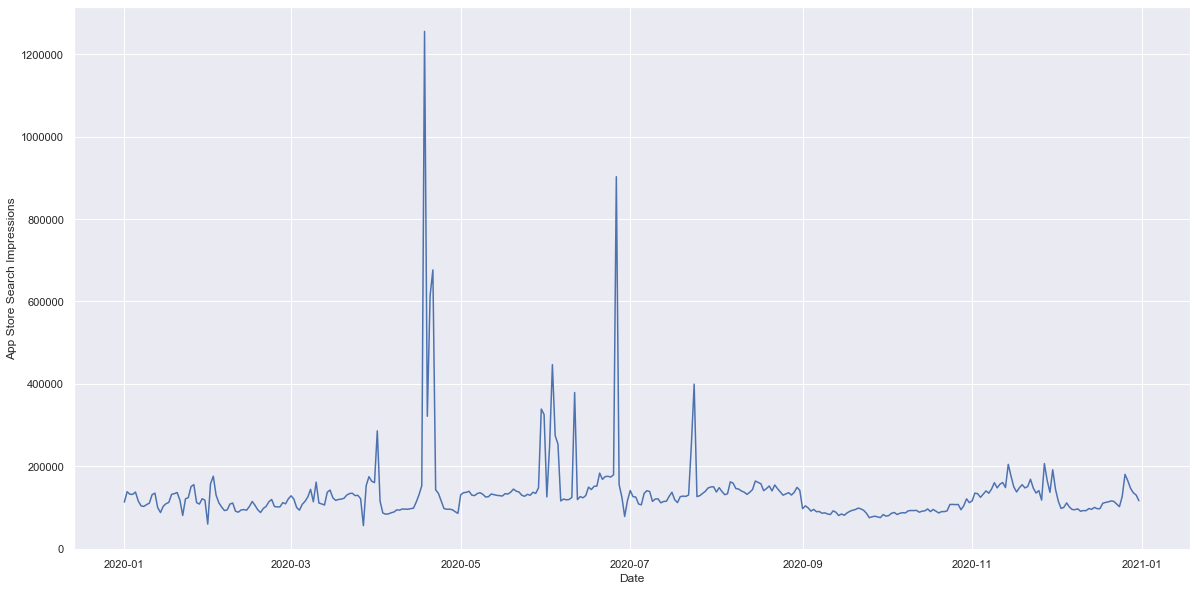

In [57]:
sns.set(rc={'figure.figsize': (20, 10)})

sns.lineplot(
    x=df.loc[df.index.year == 2020].index,
    y='App Store Search Impressions',
    # y='% Impressions From App Store Search',
    # y='% App Units From App Store Search',
    # y='App Store Search Impressions to App Units Ratio',
    # y='App Store Search to App Store Browse Impressions Ratio',
    data=df.loc[df.index.year == 2020]
    # data=df
)

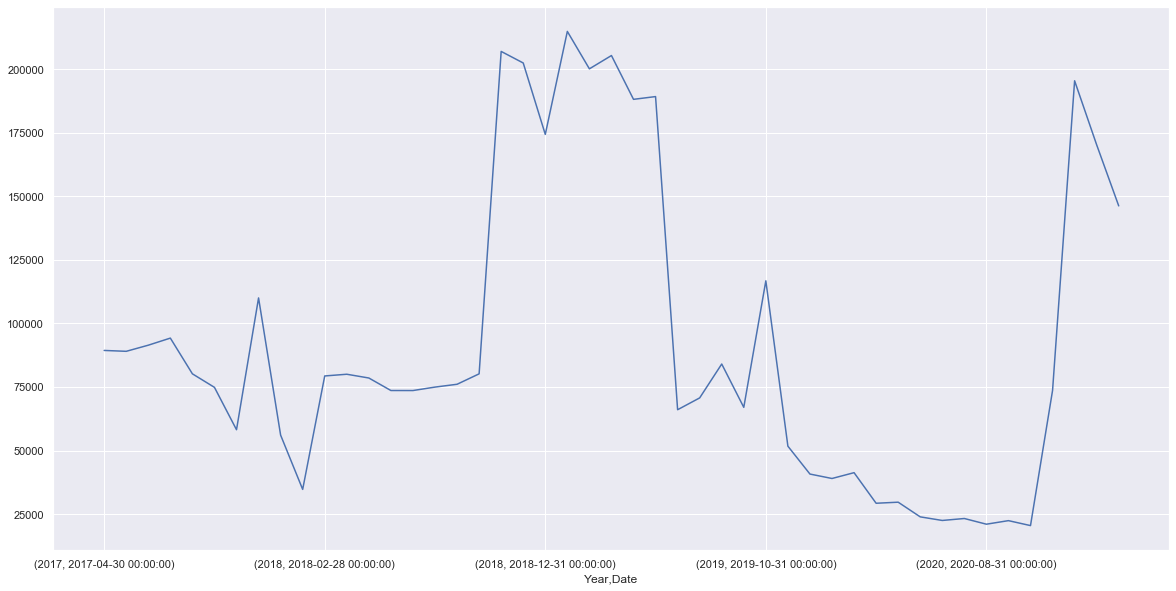

In [59]:
df.groupby('Year').resample('M')['App Store Browse Impressions'].median().plot()
# df.groupby('Year').resample('M')['% Impressions From App Store Search'].median().plot()
# df.groupby('Year').resample('M')['App Store Search App Units'].median().plot()

In [182]:
df_monthly = df.resample('M').median()

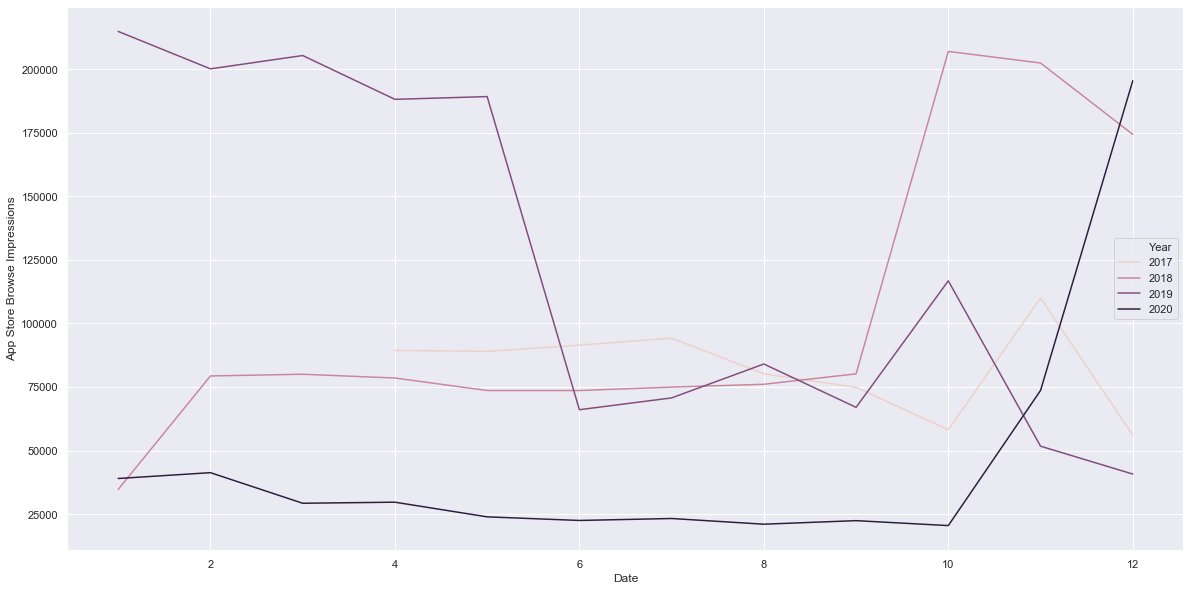

In [136]:
sns.lineplot(
    x=df_monthly[:'2020-12-31'].index.month,
    # y=df_monthly[:'2020-12-31']['App Store Search Impressions'],
    # y=df_monthly[:'2020-12-31']['App Store Search App Units'],
    # y=df_monthly[:'2020-12-31']['App Store Search to App Store Browse Impressions Ratio'],
    # y=df_monthly[:'2020-12-31']['% Impressions From App Store Search'],
    # y=df_monthly[:'2020-12-31']['App Referrer Impressions'],
    y=df_monthly[:'2020-12-31']['App Store Browse Impressions'],
    hue=df_monthly[:'2020-12-31']['Year']
)

In [64]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [69]:
# 129600 for monthly data
# 6000 for quarterly data
# 6.25 for annual data
cycle, trend = hpfilter(df_monthly['App Store Search Impressions'], 129600)

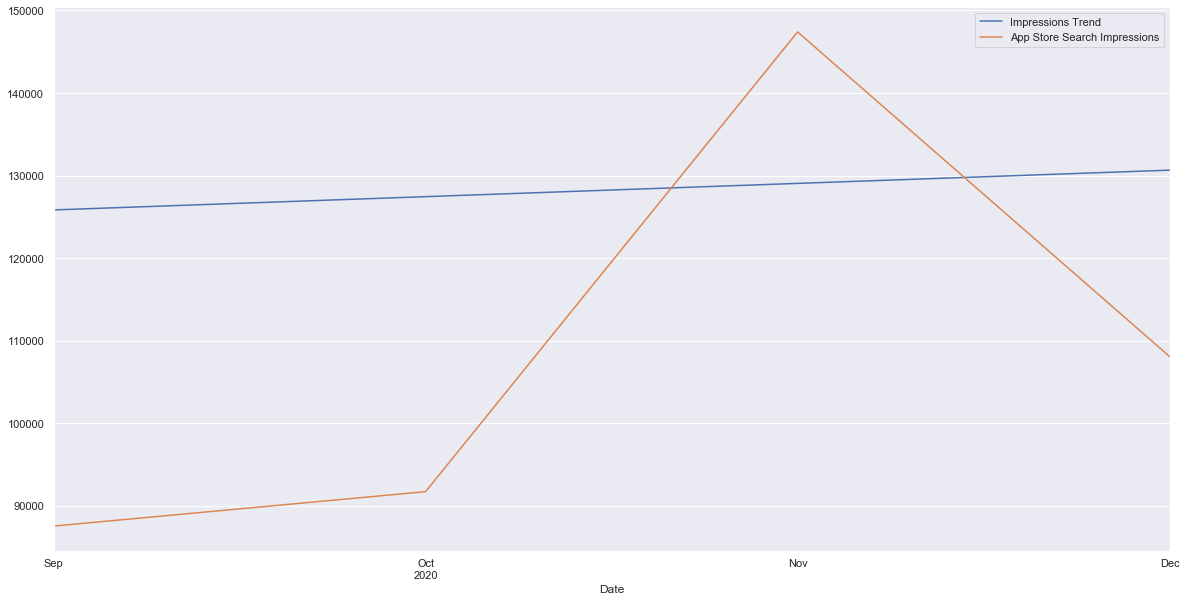

In [84]:
df_monthly['Impressions Trend'] = trend
df_monthly[['Impressions Trend', 'App Store Search Impressions']]['2020-09-01':'2020-12-31'].plot()

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [92]:
result = seasonal_decompose(df_monthly['App Store Search Impressions'], model='multiplicative')

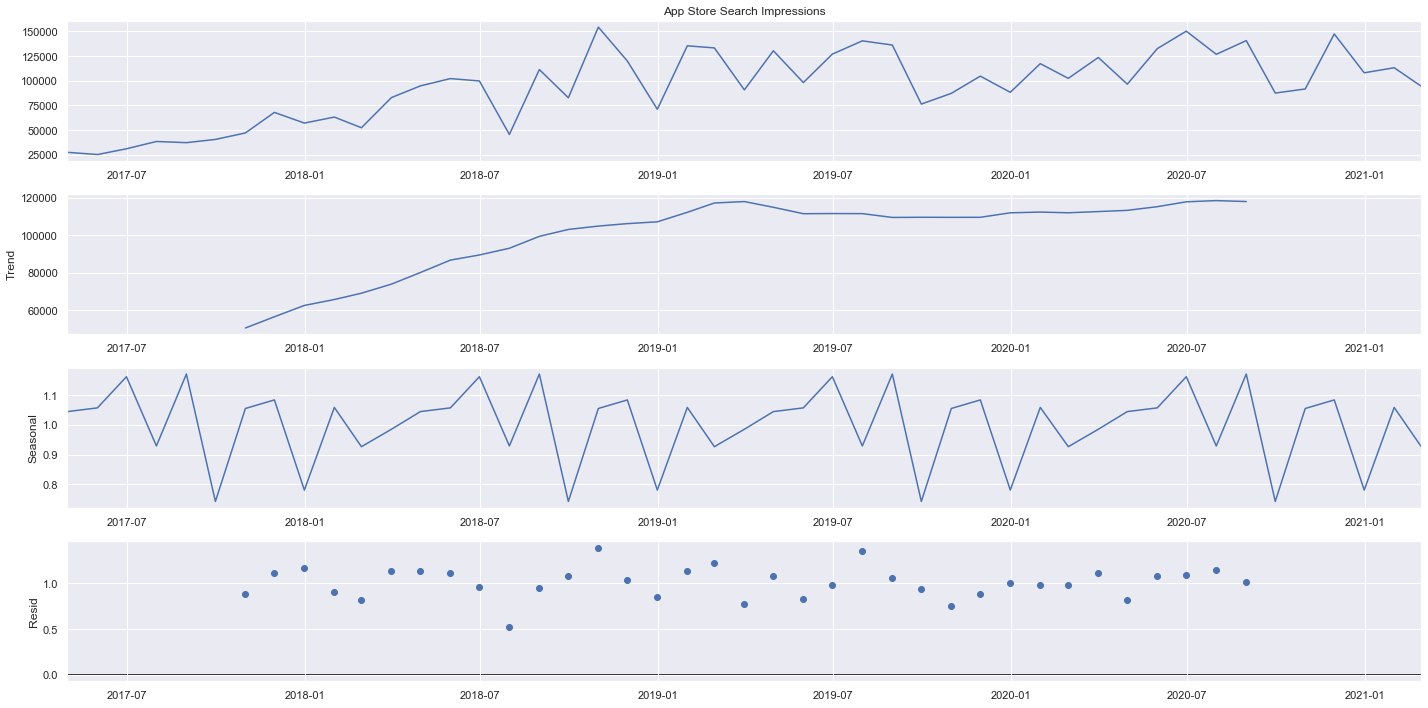

In [93]:
result.plot();

In [97]:
# Using Simple Moving Average
df_monthly['6-month-SMA'] = df_monthly['App Store Search Impressions'].rolling(window=6).mean()
df_monthly['12-month-SMA'] = df_monthly['App Store Search Impressions'].rolling(window=12).mean()

# Using Exponentially Weighted Moving Average
df_monthly['6-month-EWMA'] = df_monthly['App Store Search Impressions'].ewm(span=6).mean()
df_monthly['12-month-EWMA'] = df_monthly['App Store Search Impressions'].ewm(span=12).mean()

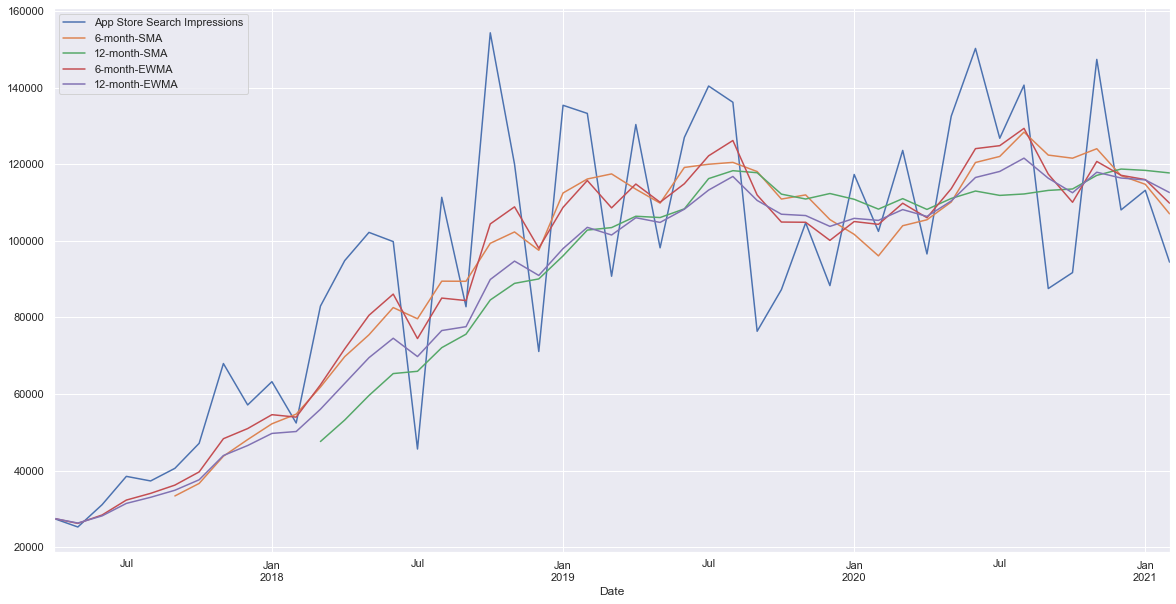

In [98]:
df_monthly[['App Store Search Impressions', '6-month-SMA', '12-month-SMA', '6-month-EWMA', '12-month-EWMA']].plot()

In [100]:
df_monthly.index

DatetimeIndex(['2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28'],
              dtype='datetime64[ns]', name='Date', freq='M')

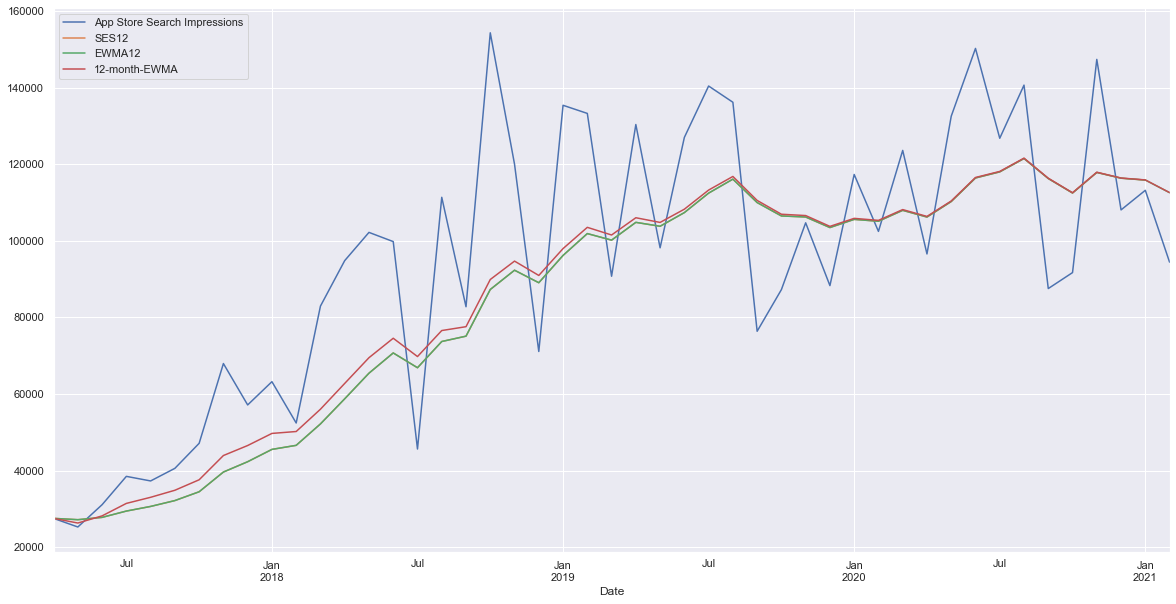

In [140]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12 # annual seasonality
alpha = 2 / (span + 1) # predetermined value given a span
df_monthly['EWMA12'] = df_monthly['App Store Search Impressions'].ewm(alpha=alpha, adjust=False).mean()

model = SimpleExpSmoothing(df_monthly['App Store Search Impressions'])
fitted_model = model.fit(smoothing_level=alpha, optimized=False)
df_monthly['SES12'] = fitted_model.fittedvalues.shift(-1)
df_monthly[['App Store Search Impressions', 'SES12', 'EWMA12', '12-month-EWMA']].plot();

In [120]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Double Exponential Smoothing
df_monthly['DES_add_12'] = ExponentialSmoothing(df_monthly['App Store Search Impressions'], trend='add').fit().fittedvalues.shift(-1)
df_monthly['DES_mul_12'] = ExponentialSmoothing(df_monthly['App Store Search Impressions'], trend='mul').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing
df_monthly['TES_add_12'] = ExponentialSmoothing(
    df_monthly['App Store Search Impressions'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12 # Annual seasonal periods
).fit().fittedvalues.shift(-1)

df_monthly['TES_mul_12'] = ExponentialSmoothing(
    df_monthly['App Store Search Impressions'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12 # Annual seasonal periods
).fit().fittedvalues.shift(-1)


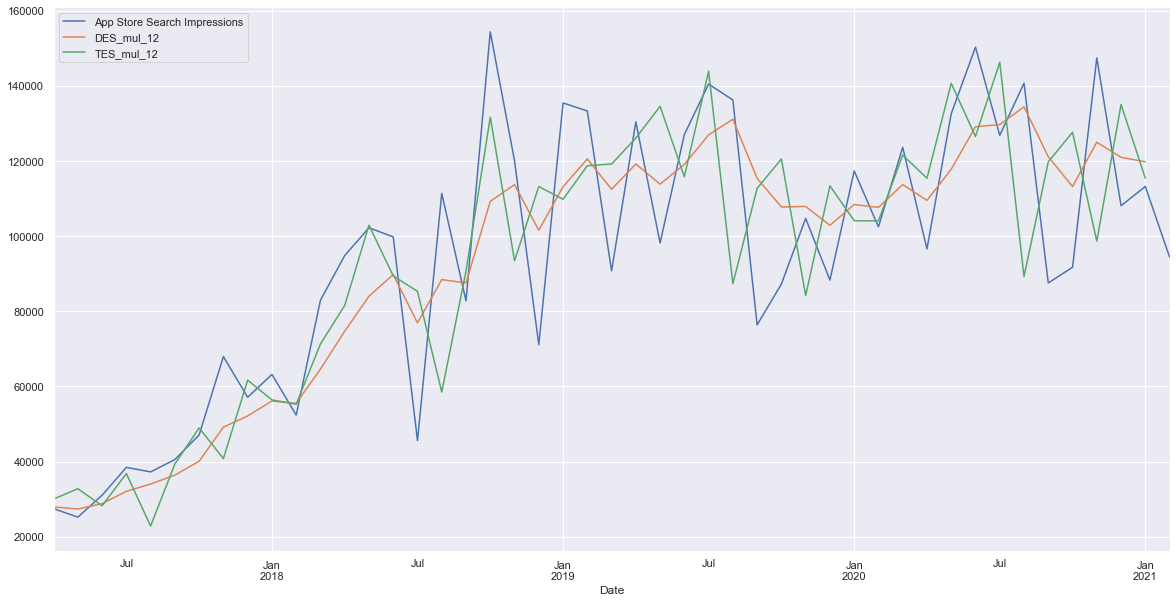

In [123]:
df_monthly[[
    'App Store Search Impressions',
    # 'EWMA12',
    # 'DES_add_12',
    'DES_mul_12',
    # 'TES_add_12',
    'TES_mul_12'
]].plot()

In [186]:
df_weekly = df.resample('W').median()
df_weekly.columns

Index(['App Referrer Impressions', 'App Store Browse Impressions',
       'App Store Search Impressions', 'Unavailable Impressions',
       'Web Referrer Impressions', 'App Referrer App Units',
       'App Store Browse App Units', 'App Store Search App Units',
       'Unavailable App Units', 'Web Referrer App Units', 'Unnamed: 11',
       'Year', 'App Store Search to App Store Browse Impressions Ratio',
       '% Impressions From App Store Search',
       '% App Units From App Store Search',
       'App Store Search Impressions to App Units Ratio', 'EWMA12'],
      dtype='object')

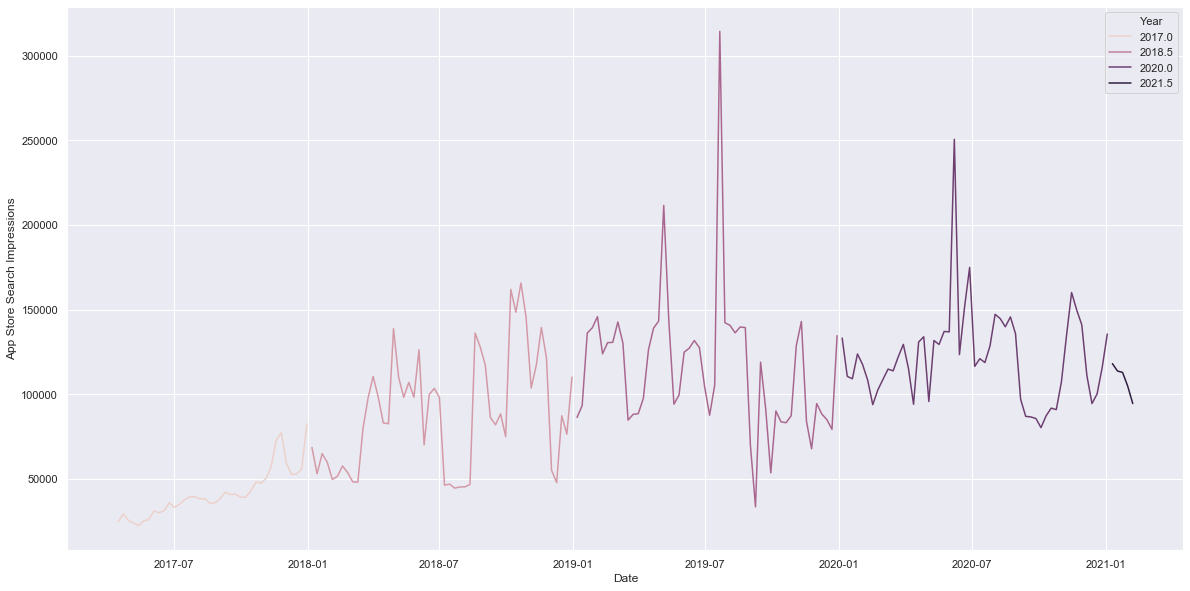

In [187]:
sns.lineplot(
    x=df_weekly.index,
    y=df_weekly['App Store Search Impressions'],
    hue=df_weekly['Year']
)

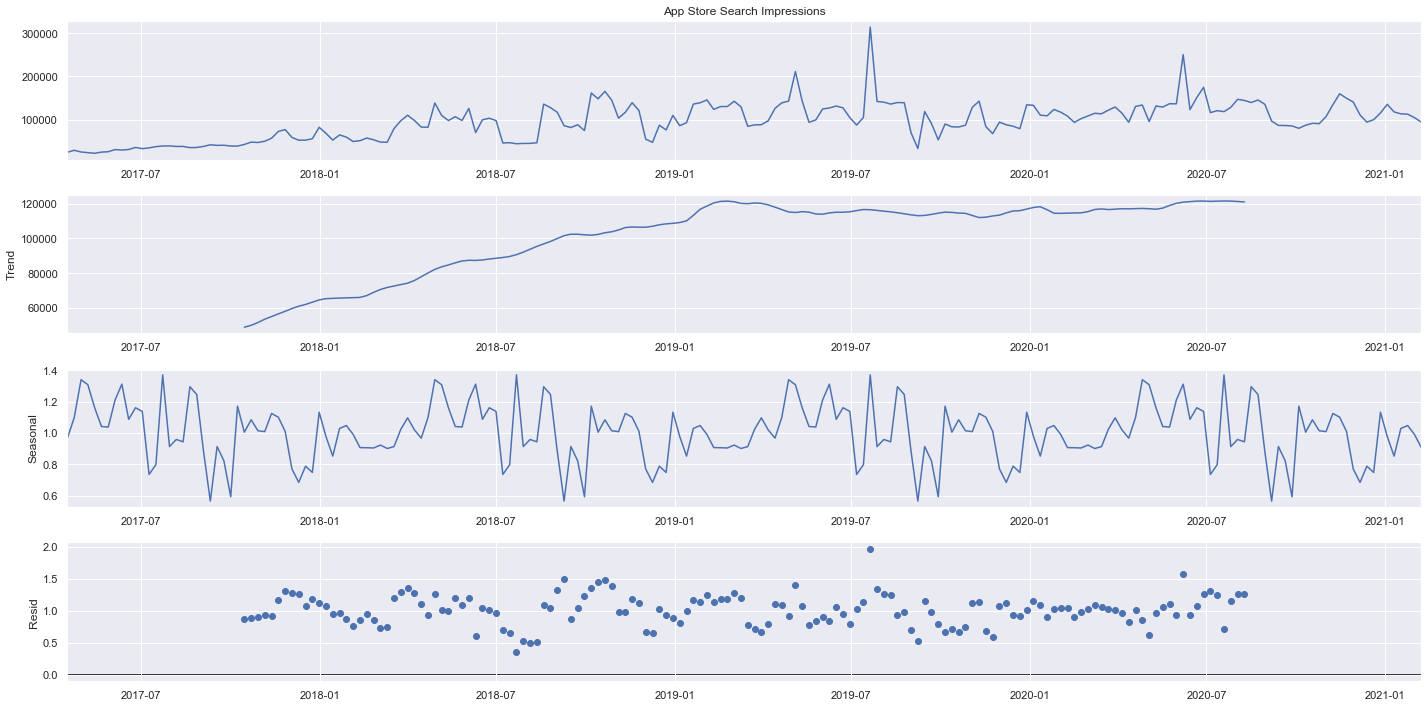

In [144]:
seasonal_decompose(df_weekly['App Store Search Impressions'], model='multiplicative').plot();

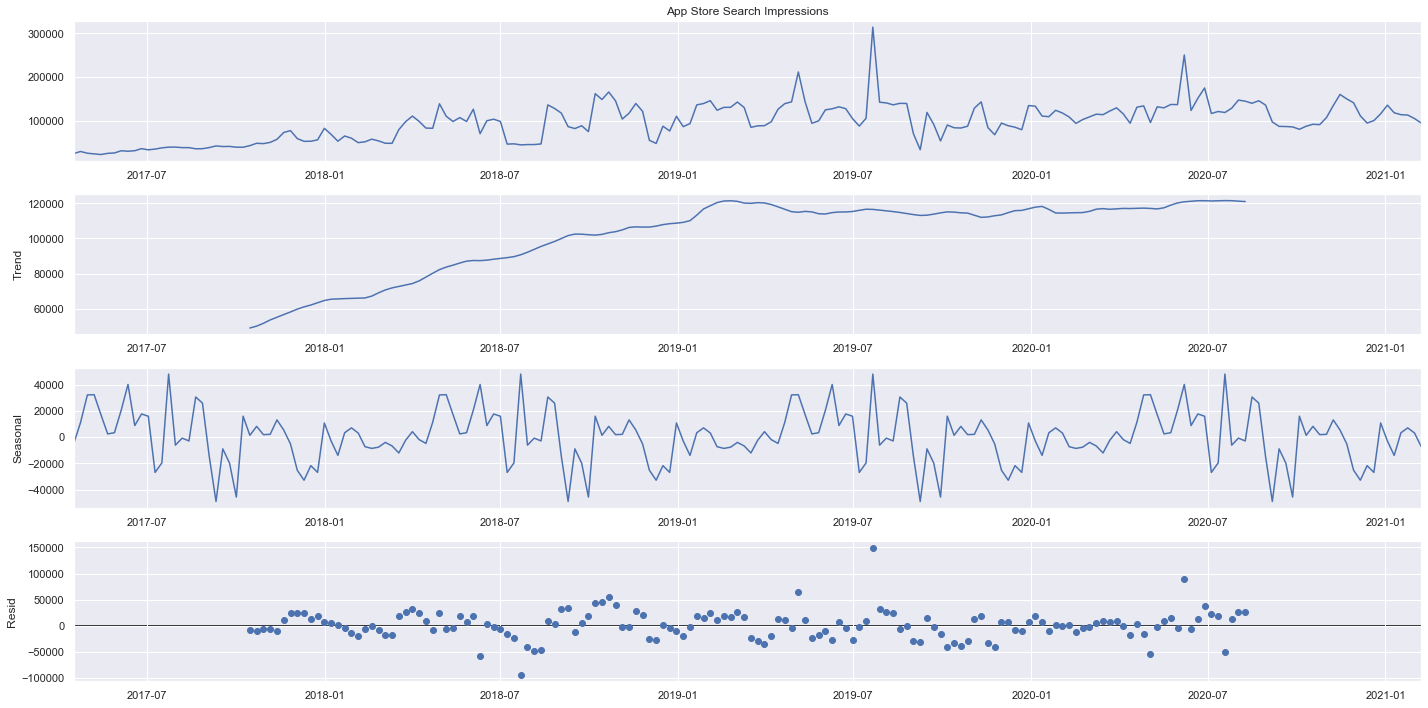

In [145]:
seasonal_decompose(df_weekly['App Store Search Impressions'], model='additive').plot();


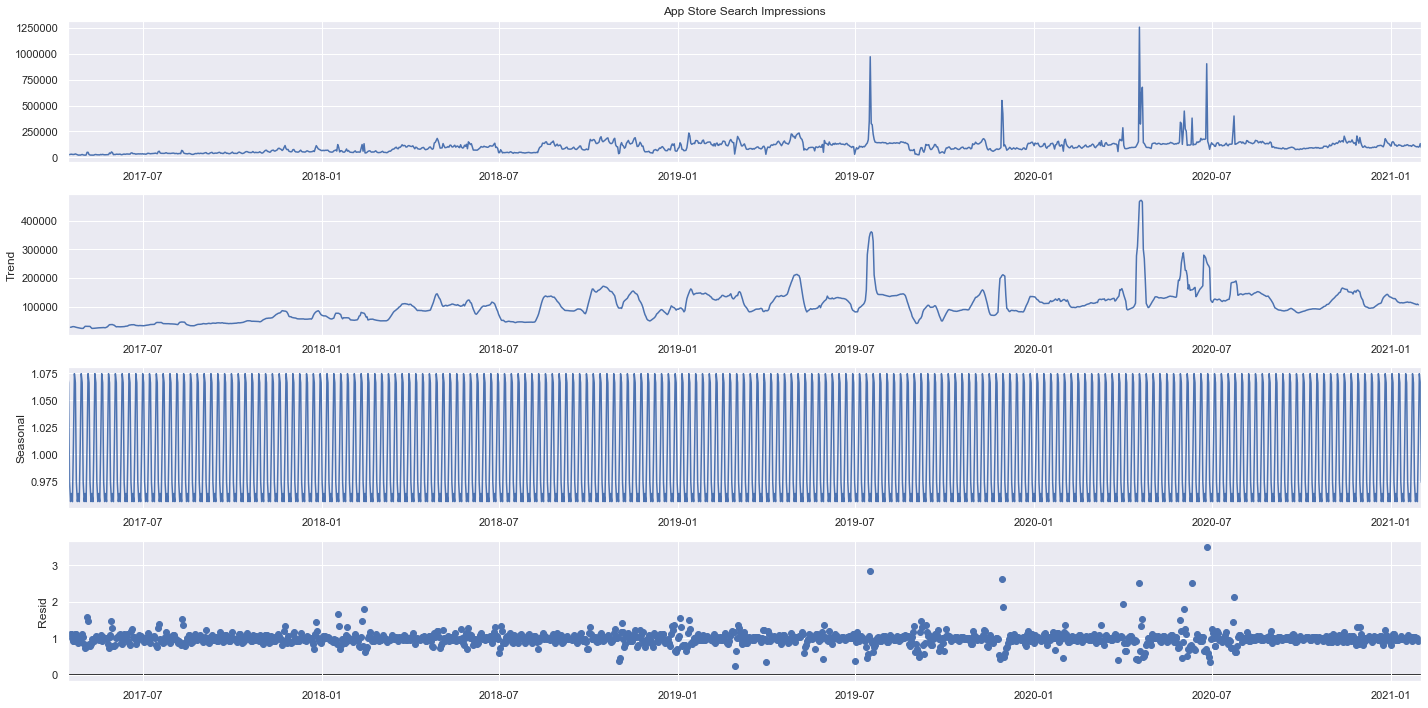

In [162]:
df.freq = 'D'
seasonal_decompose(df['App Store Search Impressions'], model='multiplicative').plot();

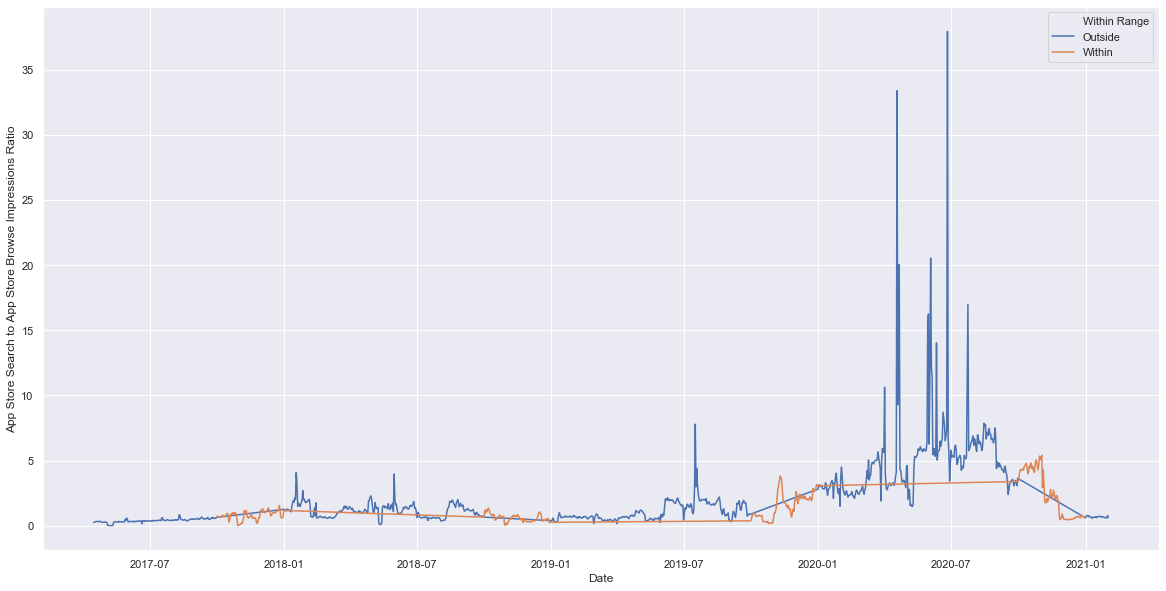

In [180]:
df['Within Range'] = df.reset_index().Date.apply(lambda x: 'Within' if x.month >= 10 else 'Outside').values

sns.lineplot(
    x=df.index,
    # y=df['App Store Search Impressions'],
    y=df['App Store Search to App Store Browse Impressions Ratio'],
    hue=df['Within Range']
)

In [177]:
df.reset_index().Date.apply(lambda x: 'Within' if x.month >= 10 else 'Outside').values

array(['Outside', 'Outside', 'Outside', ..., 'Outside', 'Outside',
       'Outside'], dtype=object)